In [2]:
#General math tools and plotting tools.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

700-1-int

Loaded 513 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


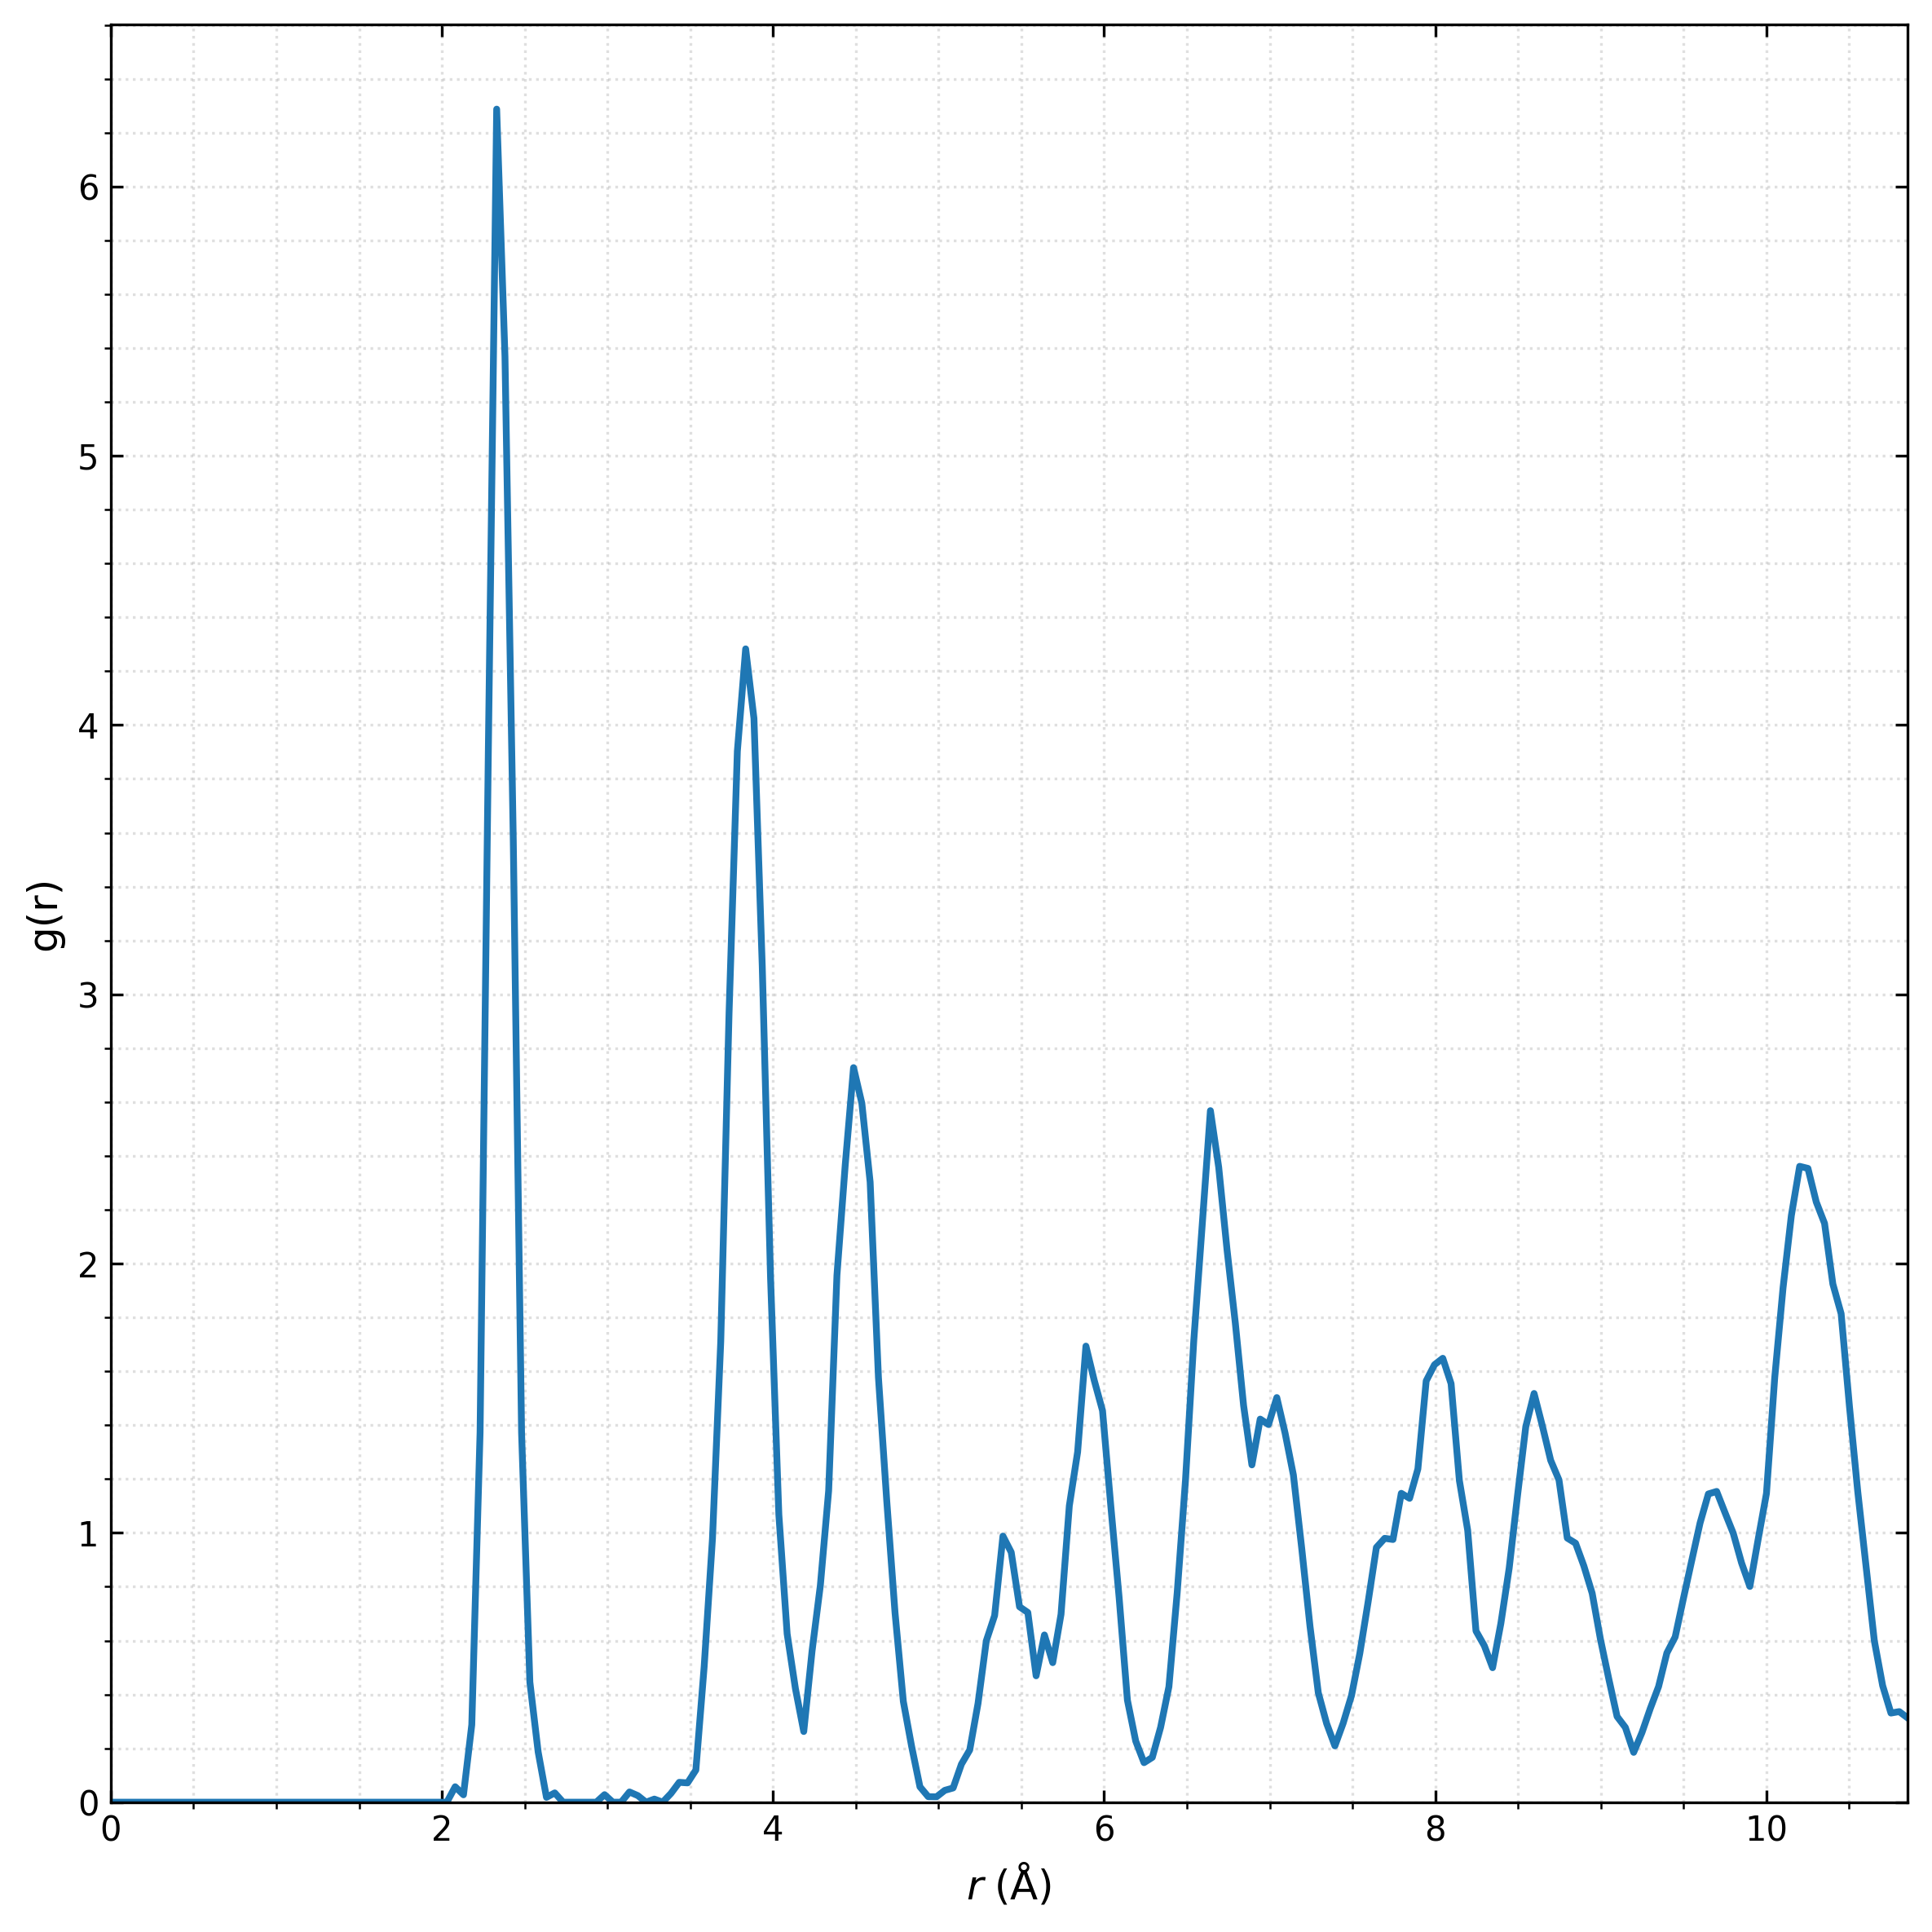

In [2]:
#Pair Correlation Function.

#Read LAMMPS file
def read_lammps_atomic_structure(filename):
    """
    Read the final structure with 'Atoms # atomic' and
    return positions (N, 3) and box length (Lx, Ly, Lz).
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    Lx = Ly = Lz = None
    atoms_start = None

    for i, line in enumerate(lines):
        if "xlo xhi" in line:
            a, b = line.split()[ : 2]
            Lx = float(b) - float(a)
        elif "ylo yhi" in line:
            a, b = line.split()[ : 2]
            Ly = float(b) - float(a)
        elif "zlo zhi" in line:
            a, b = line.split()[ : 2]
            Lz = float(b) - float(a)
        elif line.startswith("Atoms"):
            #Actual data starts third line.
            atoms_start = i + 2
            break
    
    positions = []
    for line in lines[atoms_start : ] :
        line = line.strip()
        if not line:
            break
        if line[0].isalpha():
            break
        parts = line.split()
        x, y, z = map(float, parts[2 : 5])
        positions.append([x, y, z])
    
    positions = np.array(positions, dtype = float)
    box = np.array([Lx, Ly, Lz], dtype = float)
    

    if atoms_start is None:
        raise RuntimeError("Hmmm, your simulation is not quite the same.")
    
    return positions, box

def compute_pair_correlation(positions, box, dr = 0.05, r_max = None):
    """
    Compute the pair correlation function g(r).
    Input: positions = (x, y, z); box = (Lx, Ly, Lz), dr = resolution, r_max = maximum length for 
    truncation, which is the half of the box side.

    Return the pair correlation for each atoms under considerations.
    """

    pos = np.array(positions, dtype = float)
    N = pos.shape[0]
    Lx, Ly, Lz = box
    volume = Lx * Ly * Lz
    rho = N / volume #Number density.
    #Set r_max by default:
    if r_max is None:
        r_max = 0.5 * min(box)
    
    nbins = int(r_max / dr)
    edges = np.linspace(0.0, r_max, nbins + 1)
    hist = np.zeros(nbins, dtype = float)
    #Distance between each particles.
    for i in range(N):
        d = pos - pos[i]
    #MIC
        d[:, 0] -= Lx * np.round(d[:, 0] / Lx)
        d[:, 1] -= Ly * np.round(d[:, 1] / Ly)
        d[:, 2] -= Lz * np.round(d[:, 2] / Lz)
        r = np.linalg.norm(d, axis = 1)
        #Truncations.
        cutoff = (r > 0.0) & (r < r_max)
        r_cutoff = r[cutoff]
        counts, _ = np.histogram(r_cutoff, bins = edges)
        hist += counts
    #Normalization
    g_r = np.zeros(nbins, dtype = float)
    for i in range (nbins):
        r_in = edges[i]
        r_out = edges[i + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_out ** 3 - r_in ** 3)
        n_ideal = N * rho * shell_vol
        if n_ideal > 0:
            g_r[i] = hist[i] / n_ideal

    r_centers = 0.5 * (edges[: -1] + edges[1 :])
    return r_centers, g_r

def plot_helper(r, g_r, outfile = "700 K 1 Interstitial/Pair_Correlation.png"):
    fig, ax = plt.subplots(figsize = (8, 8), dpi = 300)
    ax.plot(r, g_r, linewidth = 2.0)
    ax.set_xlabel(r"$r \; (\mathrm{\AA})$", fontsize = 12)
    ax.set_ylabel(r"g(r)", fontsize = 12)
    #May change the title based on the simulation conditions.
    ax.set_xlim(0, r.max())
    ax.set_ylim(bottom = 0)
    ax.grid(True, which = "both", linestyle = ":", alpha = 0.4)
    ax.tick_params(direction = "in", top = True, right = True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi = 300)
    plt.show()

def main():
    #Double check your files!
    data_file = "700 K 1 Interstitial/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")
    dr = 0.05
    r, g_r = compute_pair_correlation(positions, box, dr = dr)
    np.savetxt("700 K 1 Interstitial/gr.dat", np.column_stack((r, g_r)), header="r(Å)   g(r)   (FINAL_STRUCTURE)")
    plot_helper(r, g_r)

if __name__ == "__main__":
    main()

Loaded 513 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


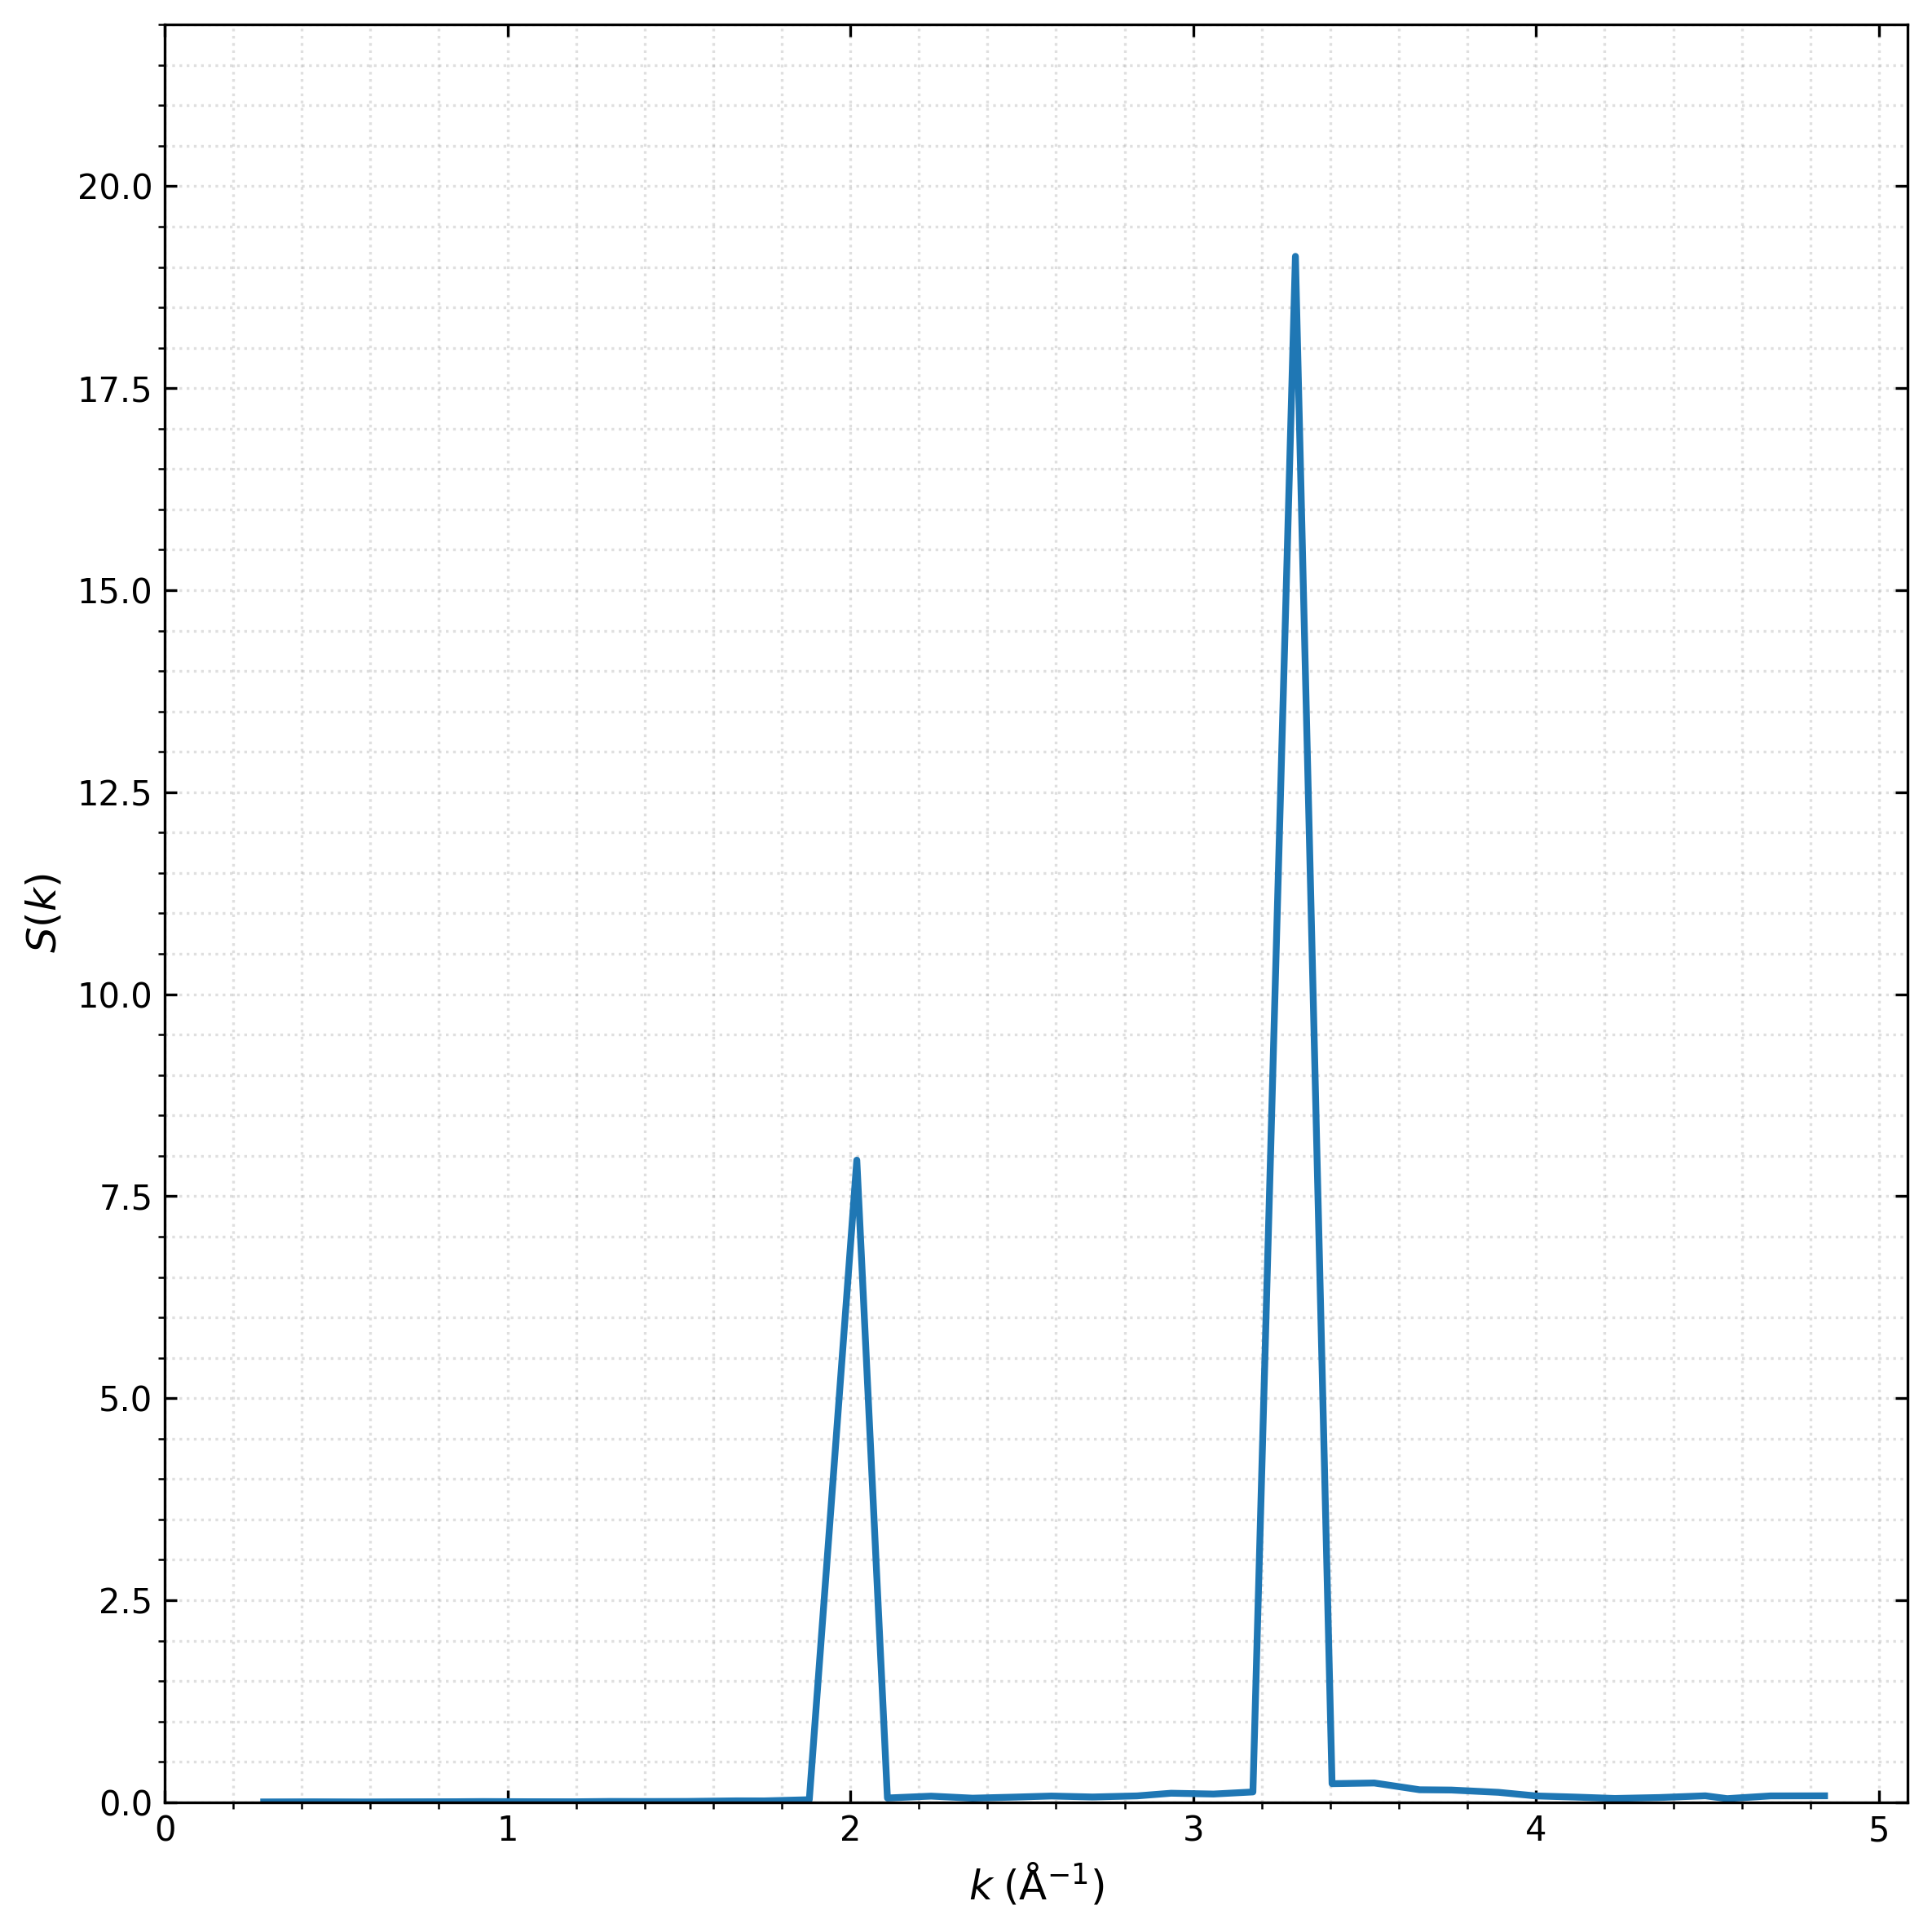

In [3]:
#Structural Factor S(K).
def legal_kvecs(maxn, L):
    """
    Generate k-vectors commensurate with the cubic box with size L.
    Only keep the all-positive octant.
    k = 2π/L * (nx, ny, nz); nx, ny, nz = 0, 1, 2, 3, ..., maxn. Set maxn = 10.
    """
    k0 = 2.0 * np.pi / float(L)
    n = np.arange(maxn + 1)
    nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")
    kvecs = np.column_stack([nx.ravel(), ny.ravel(), nz.ravel()])
    return k0 * kvecs

def calc_rhok(kvecs, pos):
    """
    ρ_k = Σ_j exp(-i k · r_j)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    phase = kvecs @ pos.T
    rhok = np.exp(-1j * phase).sum(axis = 1)
    return rhok

def calc_Sk(kvecs, pos):
    """
    S(k) = (1/N) ⟨ρ_k ρ_-k⟩ = |ρ_k|^2 / N  (single configuration)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    N = pos.shape[0]
    rhok = calc_rhok(kvecs, pos)
    Sk = (rhok * np.conjugate(rhok)).real / N
    return Sk

def compute_structure_factor(positions, box, maxn_k = 10, k_cut = None, nbins_k = 40):
    """
    Compute S(K) in single configuration.
    """
    L = float(min(box))
    kvecs_all = legal_kvecs(maxn_k, L)
    k_mag_all = np.linalg.norm(kvecs_all, axis = 1)
    #Remove k = 0
    cutoff = k_mag_all > 0
    kvecs = kvecs_all[cutoff]
    k_mag = k_mag_all[cutoff]
    #In case to zoom in for comparison, change here.
    if k_cut is not None:
        cutoff2 = k_mag < k_cut
        kvecs = kvecs[cutoff2]
        k_mag = k_mag[cutoff2]
    
    Sk = calc_Sk(kvecs, positions)

    # Bin by |k| to get isotropic S(k)
    nbins = nbins_k
    kmin, kmax = k_mag.min(), k_mag.max()
    bins = np.linspace(kmin, kmax, nbins + 1)
    bin_idx = np.digitize(k_mag, bins) - 1
    k_bin_list, Sk_bin_list = [], []

    for ib in range(nbins):
        mask_b = bin_idx == ib
        if np.any(mask_b):
            k_bin_list.append(k_mag[mask_b].mean())
            Sk_bin_list.append(Sk[mask_b].mean())

    k_bin = np.array(k_bin_list)
    Sk_bin = np.array(Sk_bin_list)
    return k_bin, Sk_bin

def plot_Sk(k, Sk, outfile = "Structure_Factor.png"):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(k, Sk, linewidth = 2.0)
    ax.set_xlabel(r"$k \; (\mathrm{\AA^{-1}})$", fontsize = 12)
    ax.set_ylabel(r"$S(k)$", fontsize = 12)
    ax.set_xlim(0, k.max() * 1.05)
    ax.set_ylim(0, Sk.max() * 1.15)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.show()

def main_Sk():
    data_file = "700 K 1 Interstitial/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")

    maxn_k = 10
    k_cut = None
    nbins_k = 40

    k_bin, Sk_bin = compute_structure_factor(
        positions, box, maxn_k=maxn_k, k_cut=k_cut, nbins_k=nbins_k
    )

    np.savetxt(
        "700 K 1 Interstitial/Sk.dat",
        np.column_stack((k_bin, Sk_bin)),
        header="k(1/Å)   S(k)   (FINAL_STRUCTURE)",
    )
    plot_Sk(k_bin, Sk_bin, outfile="700 K 1 Interstitial/Structure_Factor.png")


if __name__ == "__main__":
    main_Sk()

700-1-vac

Loaded 511 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


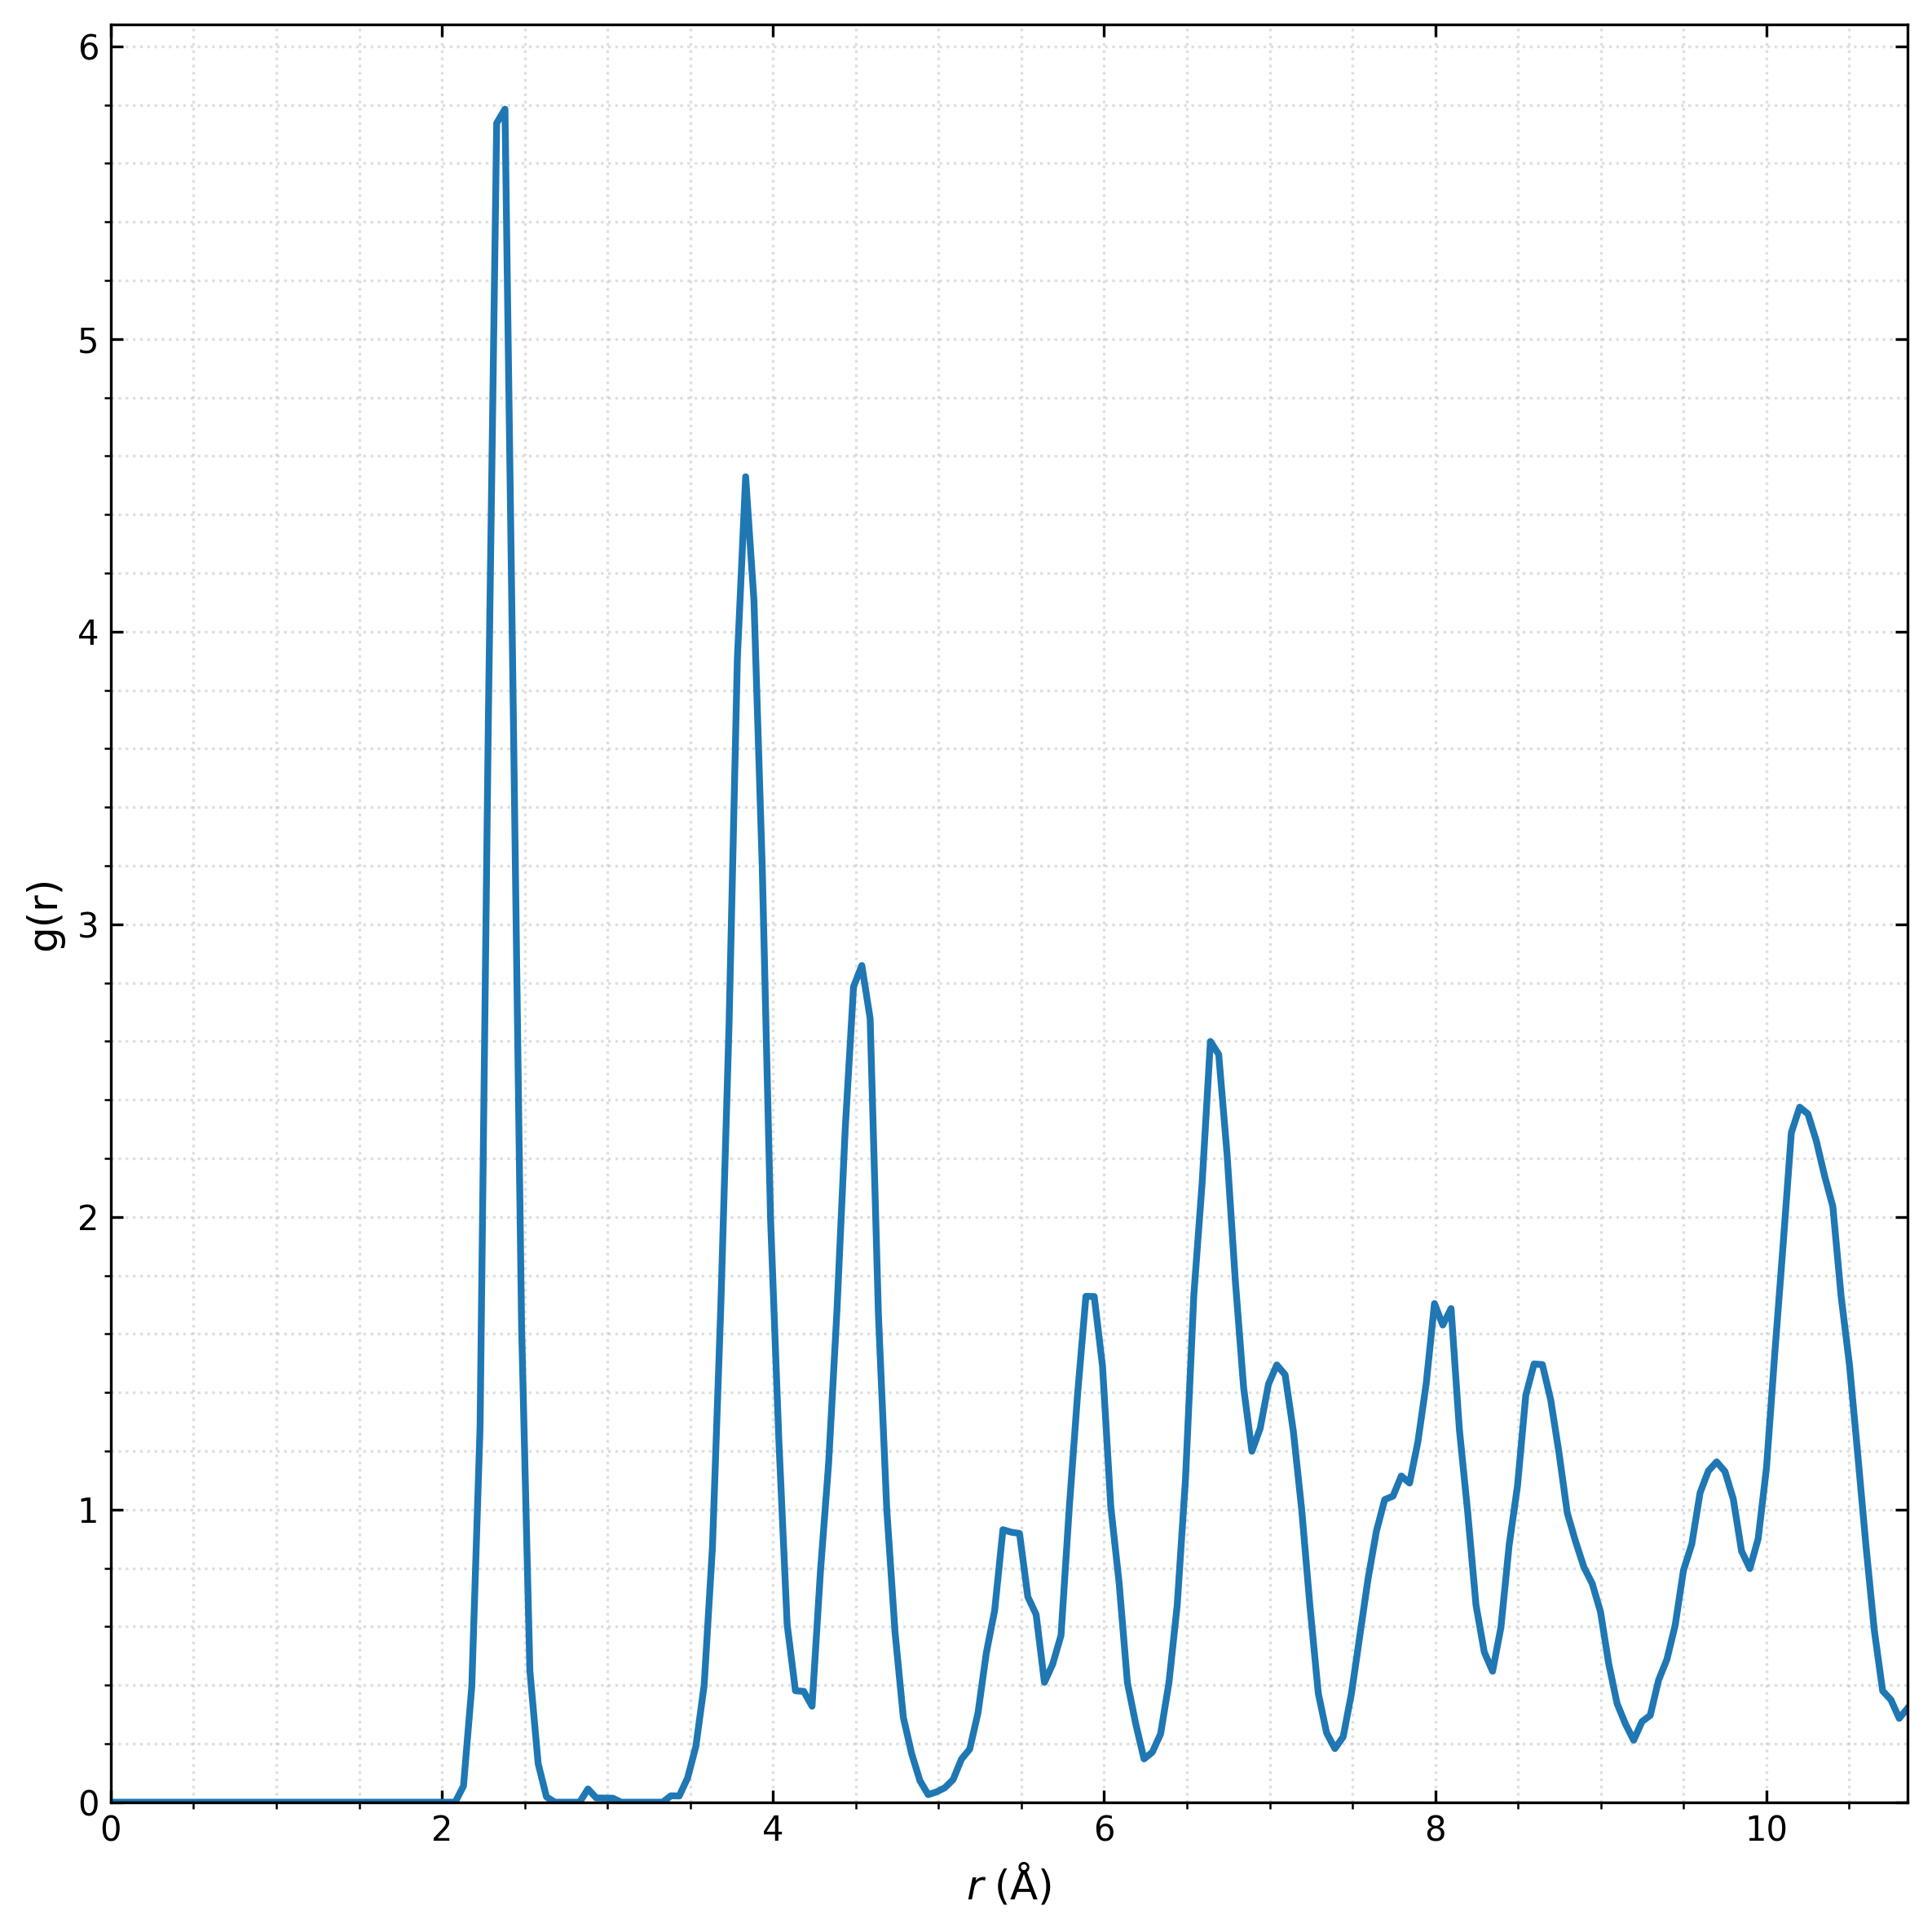

In [3]:
#Pair Correlation Function.

#Read LAMMPS file
def read_lammps_atomic_structure(filename):
    """
    Read the final structure with 'Atoms # atomic' and
    return positions (N, 3) and box length (Lx, Ly, Lz).
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    Lx = Ly = Lz = None
    atoms_start = None

    for i, line in enumerate(lines):
        if "xlo xhi" in line:
            a, b = line.split()[ : 2]
            Lx = float(b) - float(a)
        elif "ylo yhi" in line:
            a, b = line.split()[ : 2]
            Ly = float(b) - float(a)
        elif "zlo zhi" in line:
            a, b = line.split()[ : 2]
            Lz = float(b) - float(a)
        elif line.startswith("Atoms"):
            #Actual data starts third line.
            atoms_start = i + 2
            break
    
    positions = []
    for line in lines[atoms_start : ] :
        line = line.strip()
        if not line:
            break
        if line[0].isalpha():
            break
        parts = line.split()
        x, y, z = map(float, parts[2 : 5])
        positions.append([x, y, z])
    
    positions = np.array(positions, dtype = float)
    box = np.array([Lx, Ly, Lz], dtype = float)
    

    if atoms_start is None:
        raise RuntimeError("Hmmm, your simulation is not quite the same.")
    
    return positions, box

def compute_pair_correlation(positions, box, dr = 0.05, r_max = None):
    """
    Compute the pair correlation function g(r).
    Input: positions = (x, y, z); box = (Lx, Ly, Lz), dr = resolution, r_max = maximum length for 
    truncation, which is the half of the box side.

    Return the pair correlation for each atoms under considerations.
    """

    pos = np.array(positions, dtype = float)
    N = pos.shape[0]
    Lx, Ly, Lz = box
    volume = Lx * Ly * Lz
    rho = N / volume #Number density.
    #Set r_max by default:
    if r_max is None:
        r_max = 0.5 * min(box)
    
    nbins = int(r_max / dr)
    edges = np.linspace(0.0, r_max, nbins + 1)
    hist = np.zeros(nbins, dtype = float)
    #Distance between each particles.
    for i in range(N):
        d = pos - pos[i]
    #MIC
        d[:, 0] -= Lx * np.round(d[:, 0] / Lx)
        d[:, 1] -= Ly * np.round(d[:, 1] / Ly)
        d[:, 2] -= Lz * np.round(d[:, 2] / Lz)
        r = np.linalg.norm(d, axis = 1)
        #Truncations.
        cutoff = (r > 0.0) & (r < r_max)
        r_cutoff = r[cutoff]
        counts, _ = np.histogram(r_cutoff, bins = edges)
        hist += counts
    #Normalization
    g_r = np.zeros(nbins, dtype = float)
    for i in range (nbins):
        r_in = edges[i]
        r_out = edges[i + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_out ** 3 - r_in ** 3)
        n_ideal = N * rho * shell_vol
        if n_ideal > 0:
            g_r[i] = hist[i] / n_ideal

    r_centers = 0.5 * (edges[: -1] + edges[1 :])
    return r_centers, g_r

def plot_helper(r, g_r, outfile = "700 K 1 Vacancy/Pair_Correlation.png"):
    fig, ax = plt.subplots(figsize = (8, 8), dpi = 300)
    ax.plot(r, g_r, linewidth = 2.0)
    ax.set_xlabel(r"$r \; (\mathrm{\AA})$", fontsize = 12)
    ax.set_ylabel(r"g(r)", fontsize = 12)
    #May change the title based on the simulation conditions.
    ax.set_xlim(0, r.max())
    ax.set_ylim(bottom = 0)
    ax.grid(True, which = "both", linestyle = ":", alpha = 0.4)
    ax.tick_params(direction = "in", top = True, right = True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi = 300)
    plt.show()

def main():
    #Double check your files!
    data_file = "700 K 1 Vacancy/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")
    dr = 0.05
    r, g_r = compute_pair_correlation(positions, box, dr = dr)
    np.savetxt("700 K 1 Vacancy/gr.dat", np.column_stack((r, g_r)), header="r(Å)   g(r)   (FINAL_STRUCTURE)")
    plot_helper(r, g_r)

if __name__ == "__main__":
    main()

Loaded 511 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


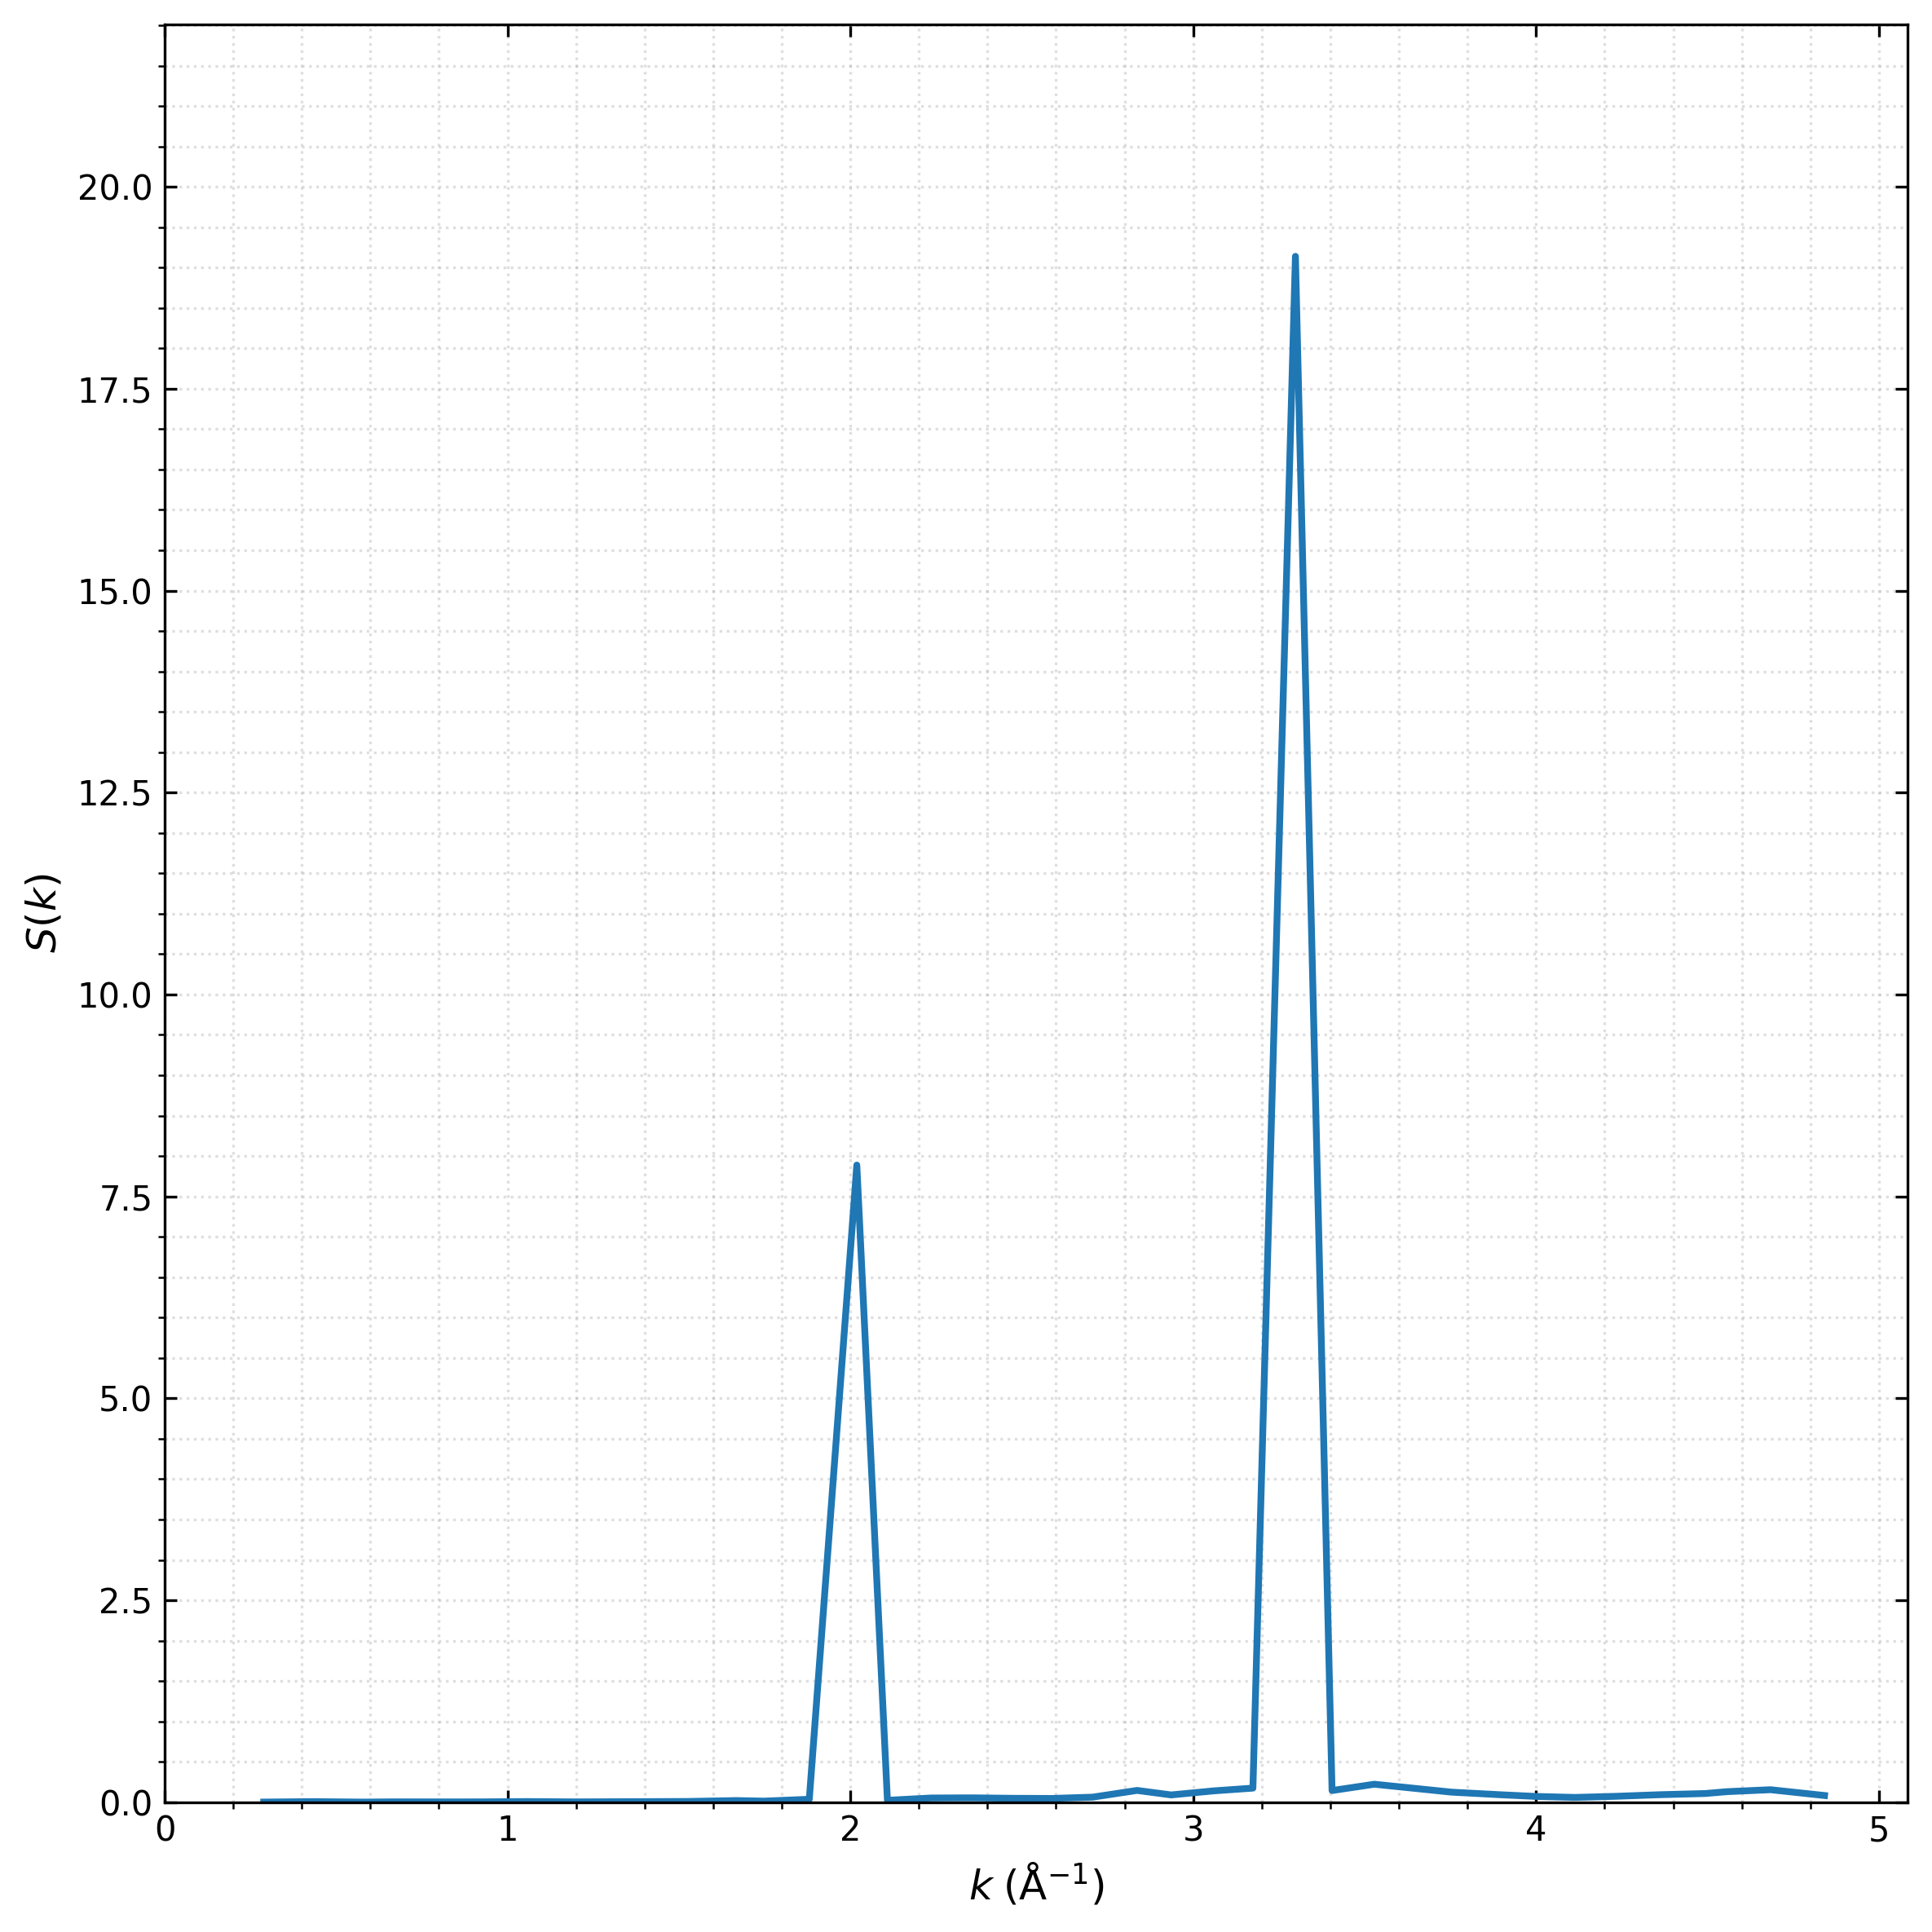

In [4]:
#Structural Factor S(K).
def legal_kvecs(maxn, L):
    """
    Generate k-vectors commensurate with the cubic box with size L.
    Only keep the all-positive octant.
    k = 2π/L * (nx, ny, nz); nx, ny, nz = 0, 1, 2, 3, ..., maxn. Set maxn = 10.
    """
    k0 = 2.0 * np.pi / float(L)
    n = np.arange(maxn + 1)
    nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")
    kvecs = np.column_stack([nx.ravel(), ny.ravel(), nz.ravel()])
    return k0 * kvecs

def calc_rhok(kvecs, pos):
    """
    ρ_k = Σ_j exp(-i k · r_j)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    phase = kvecs @ pos.T
    rhok = np.exp(-1j * phase).sum(axis = 1)
    return rhok

def calc_Sk(kvecs, pos):
    """
    S(k) = (1/N) ⟨ρ_k ρ_-k⟩ = |ρ_k|^2 / N  (single configuration)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    N = pos.shape[0]
    rhok = calc_rhok(kvecs, pos)
    Sk = (rhok * np.conjugate(rhok)).real / N
    return Sk

def compute_structure_factor(positions, box, maxn_k = 10, k_cut = None, nbins_k = 40):
    """
    Compute S(K) in single configuration.
    """
    L = float(min(box))
    kvecs_all = legal_kvecs(maxn_k, L)
    k_mag_all = np.linalg.norm(kvecs_all, axis = 1)
    #Remove k = 0
    cutoff = k_mag_all > 0
    kvecs = kvecs_all[cutoff]
    k_mag = k_mag_all[cutoff]
    #In case to zoom in for comparison, change here.
    if k_cut is not None:
        cutoff2 = k_mag < k_cut
        kvecs = kvecs[cutoff2]
        k_mag = k_mag[cutoff2]
    
    Sk = calc_Sk(kvecs, positions)

    # Bin by |k| to get isotropic S(k)
    nbins = nbins_k
    kmin, kmax = k_mag.min(), k_mag.max()
    bins = np.linspace(kmin, kmax, nbins + 1)
    bin_idx = np.digitize(k_mag, bins) - 1
    k_bin_list, Sk_bin_list = [], []

    for ib in range(nbins):
        mask_b = bin_idx == ib
        if np.any(mask_b):
            k_bin_list.append(k_mag[mask_b].mean())
            Sk_bin_list.append(Sk[mask_b].mean())

    k_bin = np.array(k_bin_list)
    Sk_bin = np.array(Sk_bin_list)
    return k_bin, Sk_bin

def plot_Sk(k, Sk, outfile = "Structure_Factor.png"):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(k, Sk, linewidth = 2.0)
    ax.set_xlabel(r"$k \; (\mathrm{\AA^{-1}})$", fontsize = 12)
    ax.set_ylabel(r"$S(k)$", fontsize = 12)
    ax.set_xlim(0, k.max() * 1.05)
    ax.set_ylim(0, Sk.max() * 1.15)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.show()

def main_Sk():
    data_file = "700 K 1 Vacancy/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")

    maxn_k = 10
    k_cut = None
    nbins_k = 40

    k_bin, Sk_bin = compute_structure_factor(
        positions, box, maxn_k=maxn_k, k_cut=k_cut, nbins_k=nbins_k
    )

    np.savetxt(
        "700 K 1 Vacancy/Sk.dat",
        np.column_stack((k_bin, Sk_bin)),
        header="k(1/Å)   S(k)   (FINAL_STRUCTURE)",
    )
    plot_Sk(k_bin, Sk_bin, outfile="700 K 1 Vacancy/Structure_Factor.png")


if __name__ == "__main__":
    main_Sk()

700-5-int

Loaded 507 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


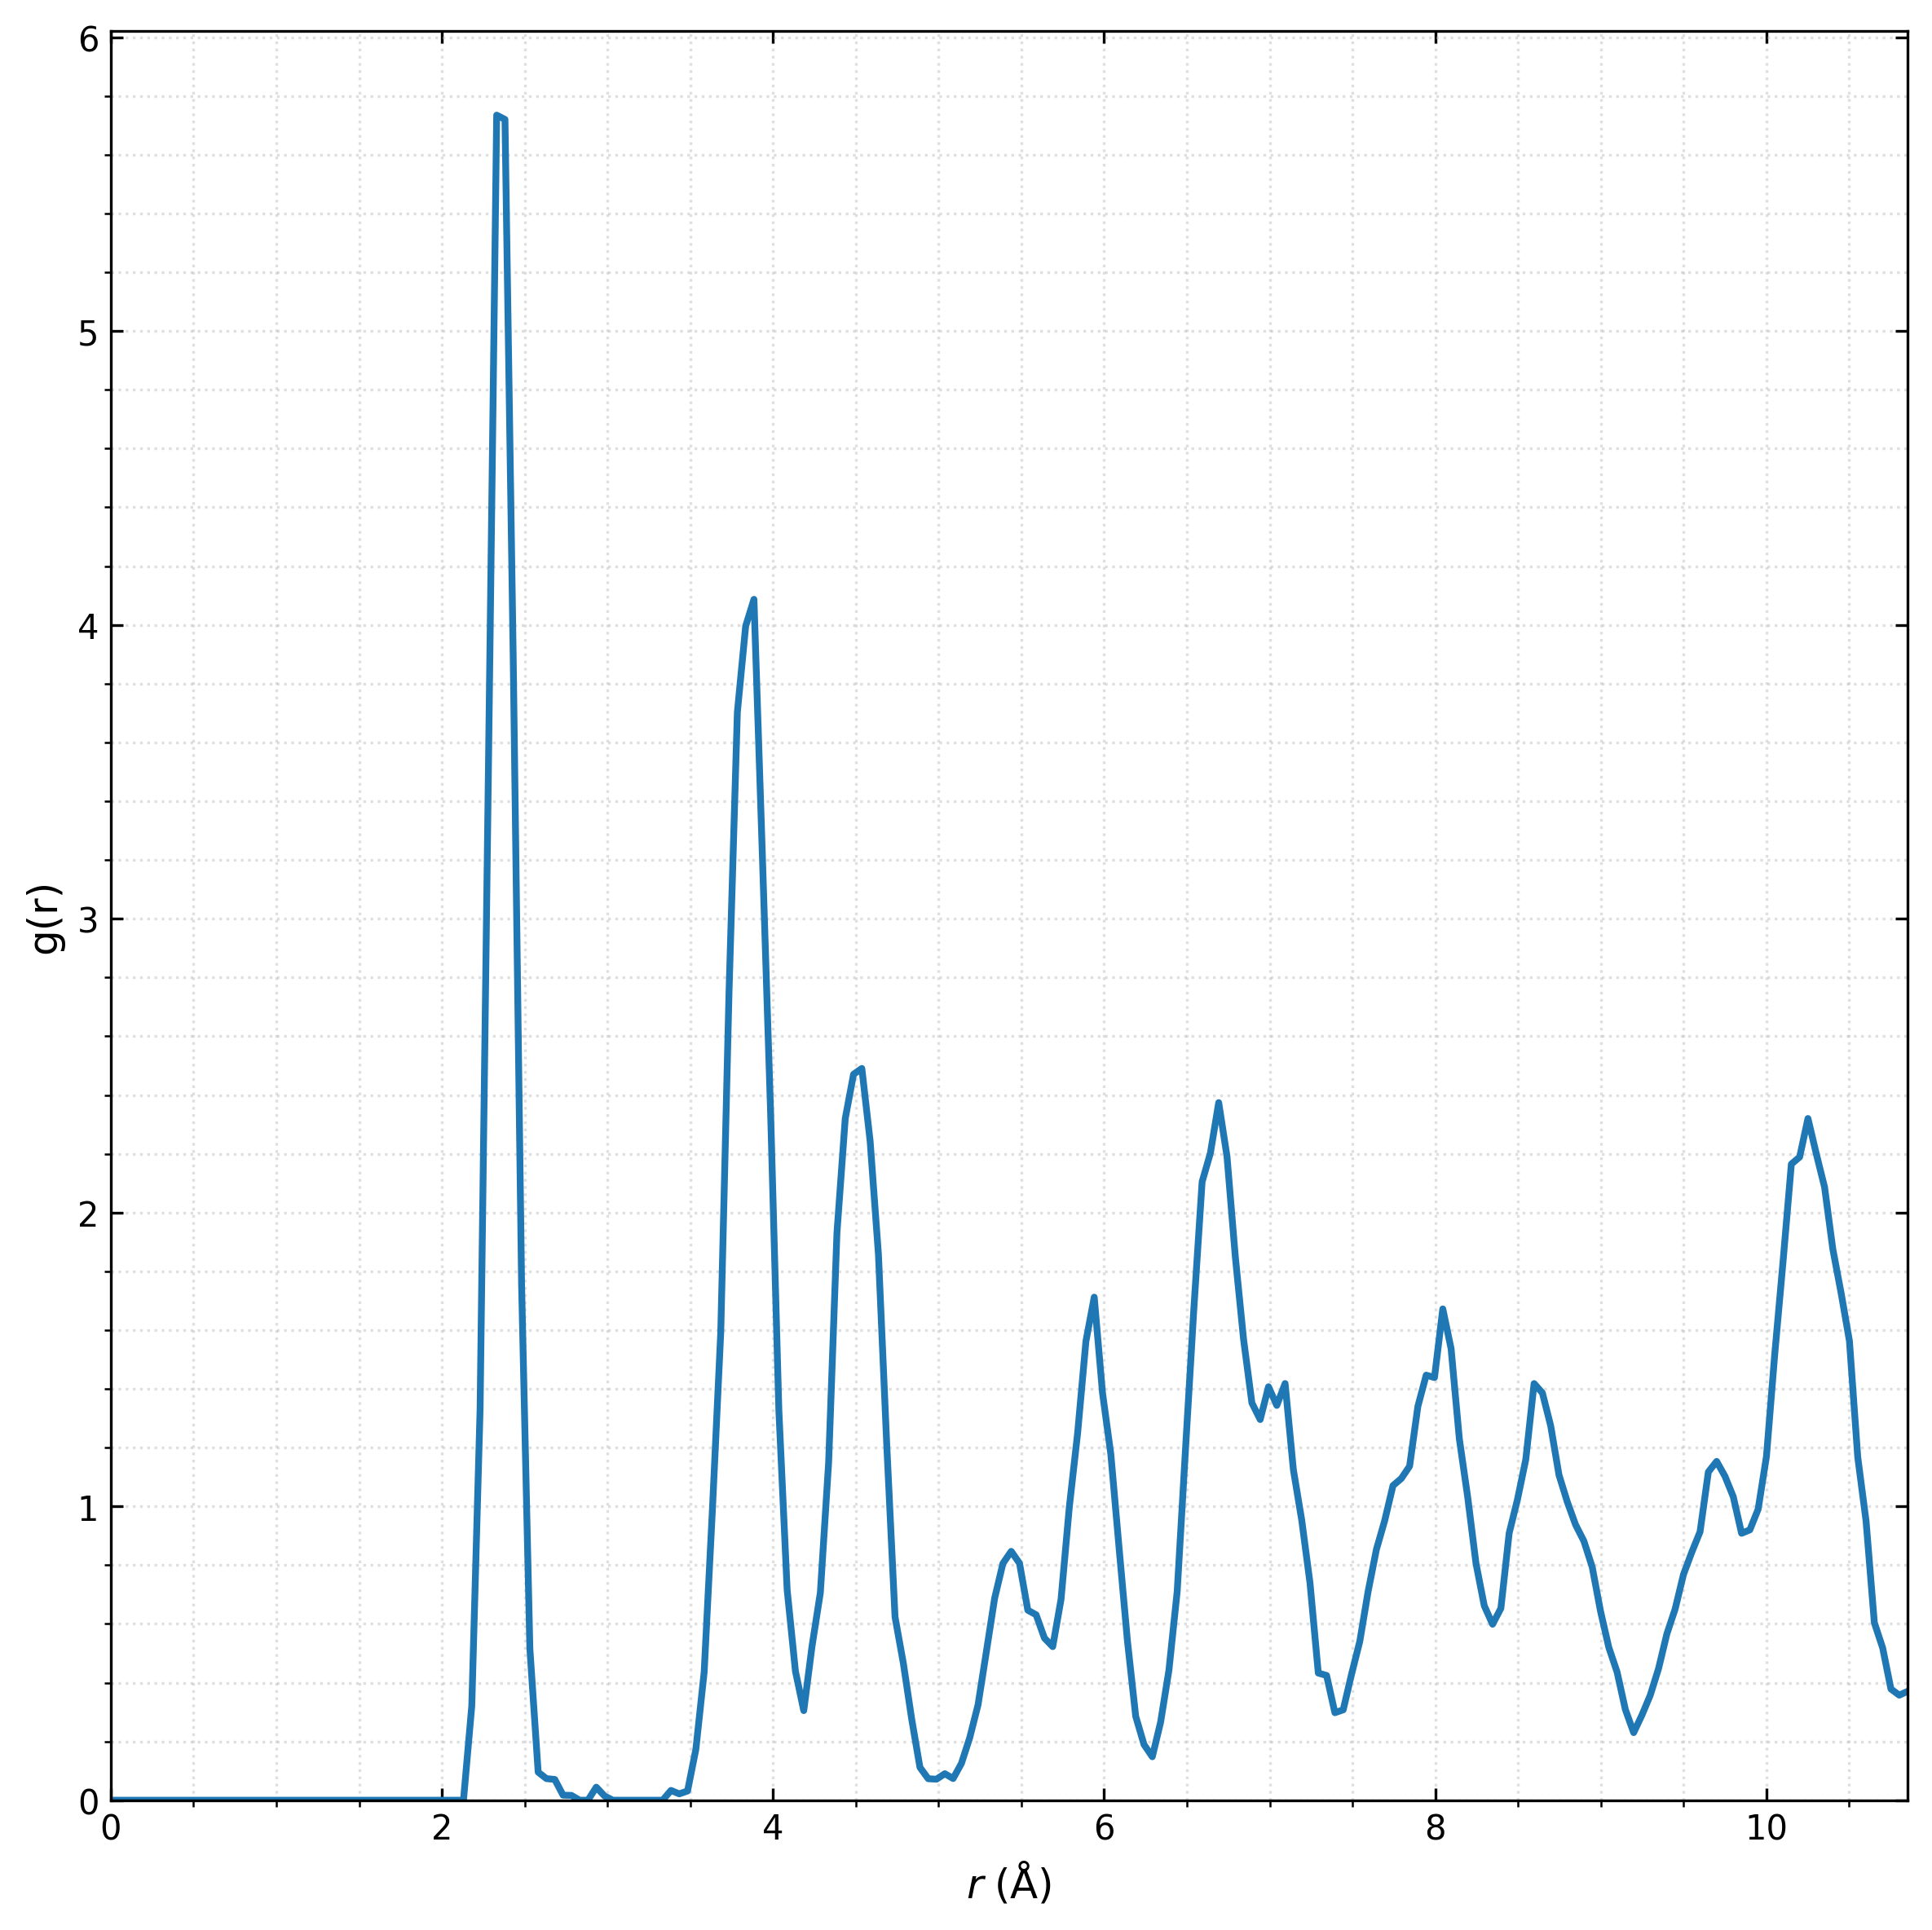

In [5]:
#Pair Correlation Function.

#Read LAMMPS file
def read_lammps_atomic_structure(filename):
    """
    Read the final structure with 'Atoms # atomic' and
    return positions (N, 3) and box length (Lx, Ly, Lz).
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    Lx = Ly = Lz = None
    atoms_start = None

    for i, line in enumerate(lines):
        if "xlo xhi" in line:
            a, b = line.split()[ : 2]
            Lx = float(b) - float(a)
        elif "ylo yhi" in line:
            a, b = line.split()[ : 2]
            Ly = float(b) - float(a)
        elif "zlo zhi" in line:
            a, b = line.split()[ : 2]
            Lz = float(b) - float(a)
        elif line.startswith("Atoms"):
            #Actual data starts third line.
            atoms_start = i + 2
            break
    
    positions = []
    for line in lines[atoms_start : ] :
        line = line.strip()
        if not line:
            break
        if line[0].isalpha():
            break
        parts = line.split()
        x, y, z = map(float, parts[2 : 5])
        positions.append([x, y, z])
    
    positions = np.array(positions, dtype = float)
    box = np.array([Lx, Ly, Lz], dtype = float)
    

    if atoms_start is None:
        raise RuntimeError("Hmmm, your simulation is not quite the same.")
    
    return positions, box

def compute_pair_correlation(positions, box, dr = 0.05, r_max = None):
    """
    Compute the pair correlation function g(r).
    Input: positions = (x, y, z); box = (Lx, Ly, Lz), dr = resolution, r_max = maximum length for 
    truncation, which is the half of the box side.

    Return the pair correlation for each atoms under considerations.
    """

    pos = np.array(positions, dtype = float)
    N = pos.shape[0]
    Lx, Ly, Lz = box
    volume = Lx * Ly * Lz
    rho = N / volume #Number density.
    #Set r_max by default:
    if r_max is None:
        r_max = 0.5 * min(box)
    
    nbins = int(r_max / dr)
    edges = np.linspace(0.0, r_max, nbins + 1)
    hist = np.zeros(nbins, dtype = float)
    #Distance between each particles.
    for i in range(N):
        d = pos - pos[i]
    #MIC
        d[:, 0] -= Lx * np.round(d[:, 0] / Lx)
        d[:, 1] -= Ly * np.round(d[:, 1] / Ly)
        d[:, 2] -= Lz * np.round(d[:, 2] / Lz)
        r = np.linalg.norm(d, axis = 1)
        #Truncations.
        cutoff = (r > 0.0) & (r < r_max)
        r_cutoff = r[cutoff]
        counts, _ = np.histogram(r_cutoff, bins = edges)
        hist += counts
    #Normalization
    g_r = np.zeros(nbins, dtype = float)
    for i in range (nbins):
        r_in = edges[i]
        r_out = edges[i + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_out ** 3 - r_in ** 3)
        n_ideal = N * rho * shell_vol
        if n_ideal > 0:
            g_r[i] = hist[i] / n_ideal

    r_centers = 0.5 * (edges[: -1] + edges[1 :])
    return r_centers, g_r

def plot_helper(r, g_r, outfile = "700 K 5 Vacancy/Pair_Correlation.png"):
    fig, ax = plt.subplots(figsize = (8, 8), dpi = 300)
    ax.plot(r, g_r, linewidth = 2.0)
    ax.set_xlabel(r"$r \; (\mathrm{\AA})$", fontsize = 12)
    ax.set_ylabel(r"g(r)", fontsize = 12)
    #May change the title based on the simulation conditions.
    ax.set_xlim(0, r.max())
    ax.set_ylim(bottom = 0)
    ax.grid(True, which = "both", linestyle = ":", alpha = 0.4)
    ax.tick_params(direction = "in", top = True, right = True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi = 300)
    plt.show()

def main():
    #Double check your files!
    data_file = "700 K 5 Vacancy/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")
    dr = 0.05
    r, g_r = compute_pair_correlation(positions, box, dr = dr)
    np.savetxt("700 K 5 Vacancy/gr.dat", np.column_stack((r, g_r)), header="r(Å)   g(r)   (FINAL_STRUCTURE)")
    plot_helper(r, g_r)

if __name__ == "__main__":
    main()

Loaded 507 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


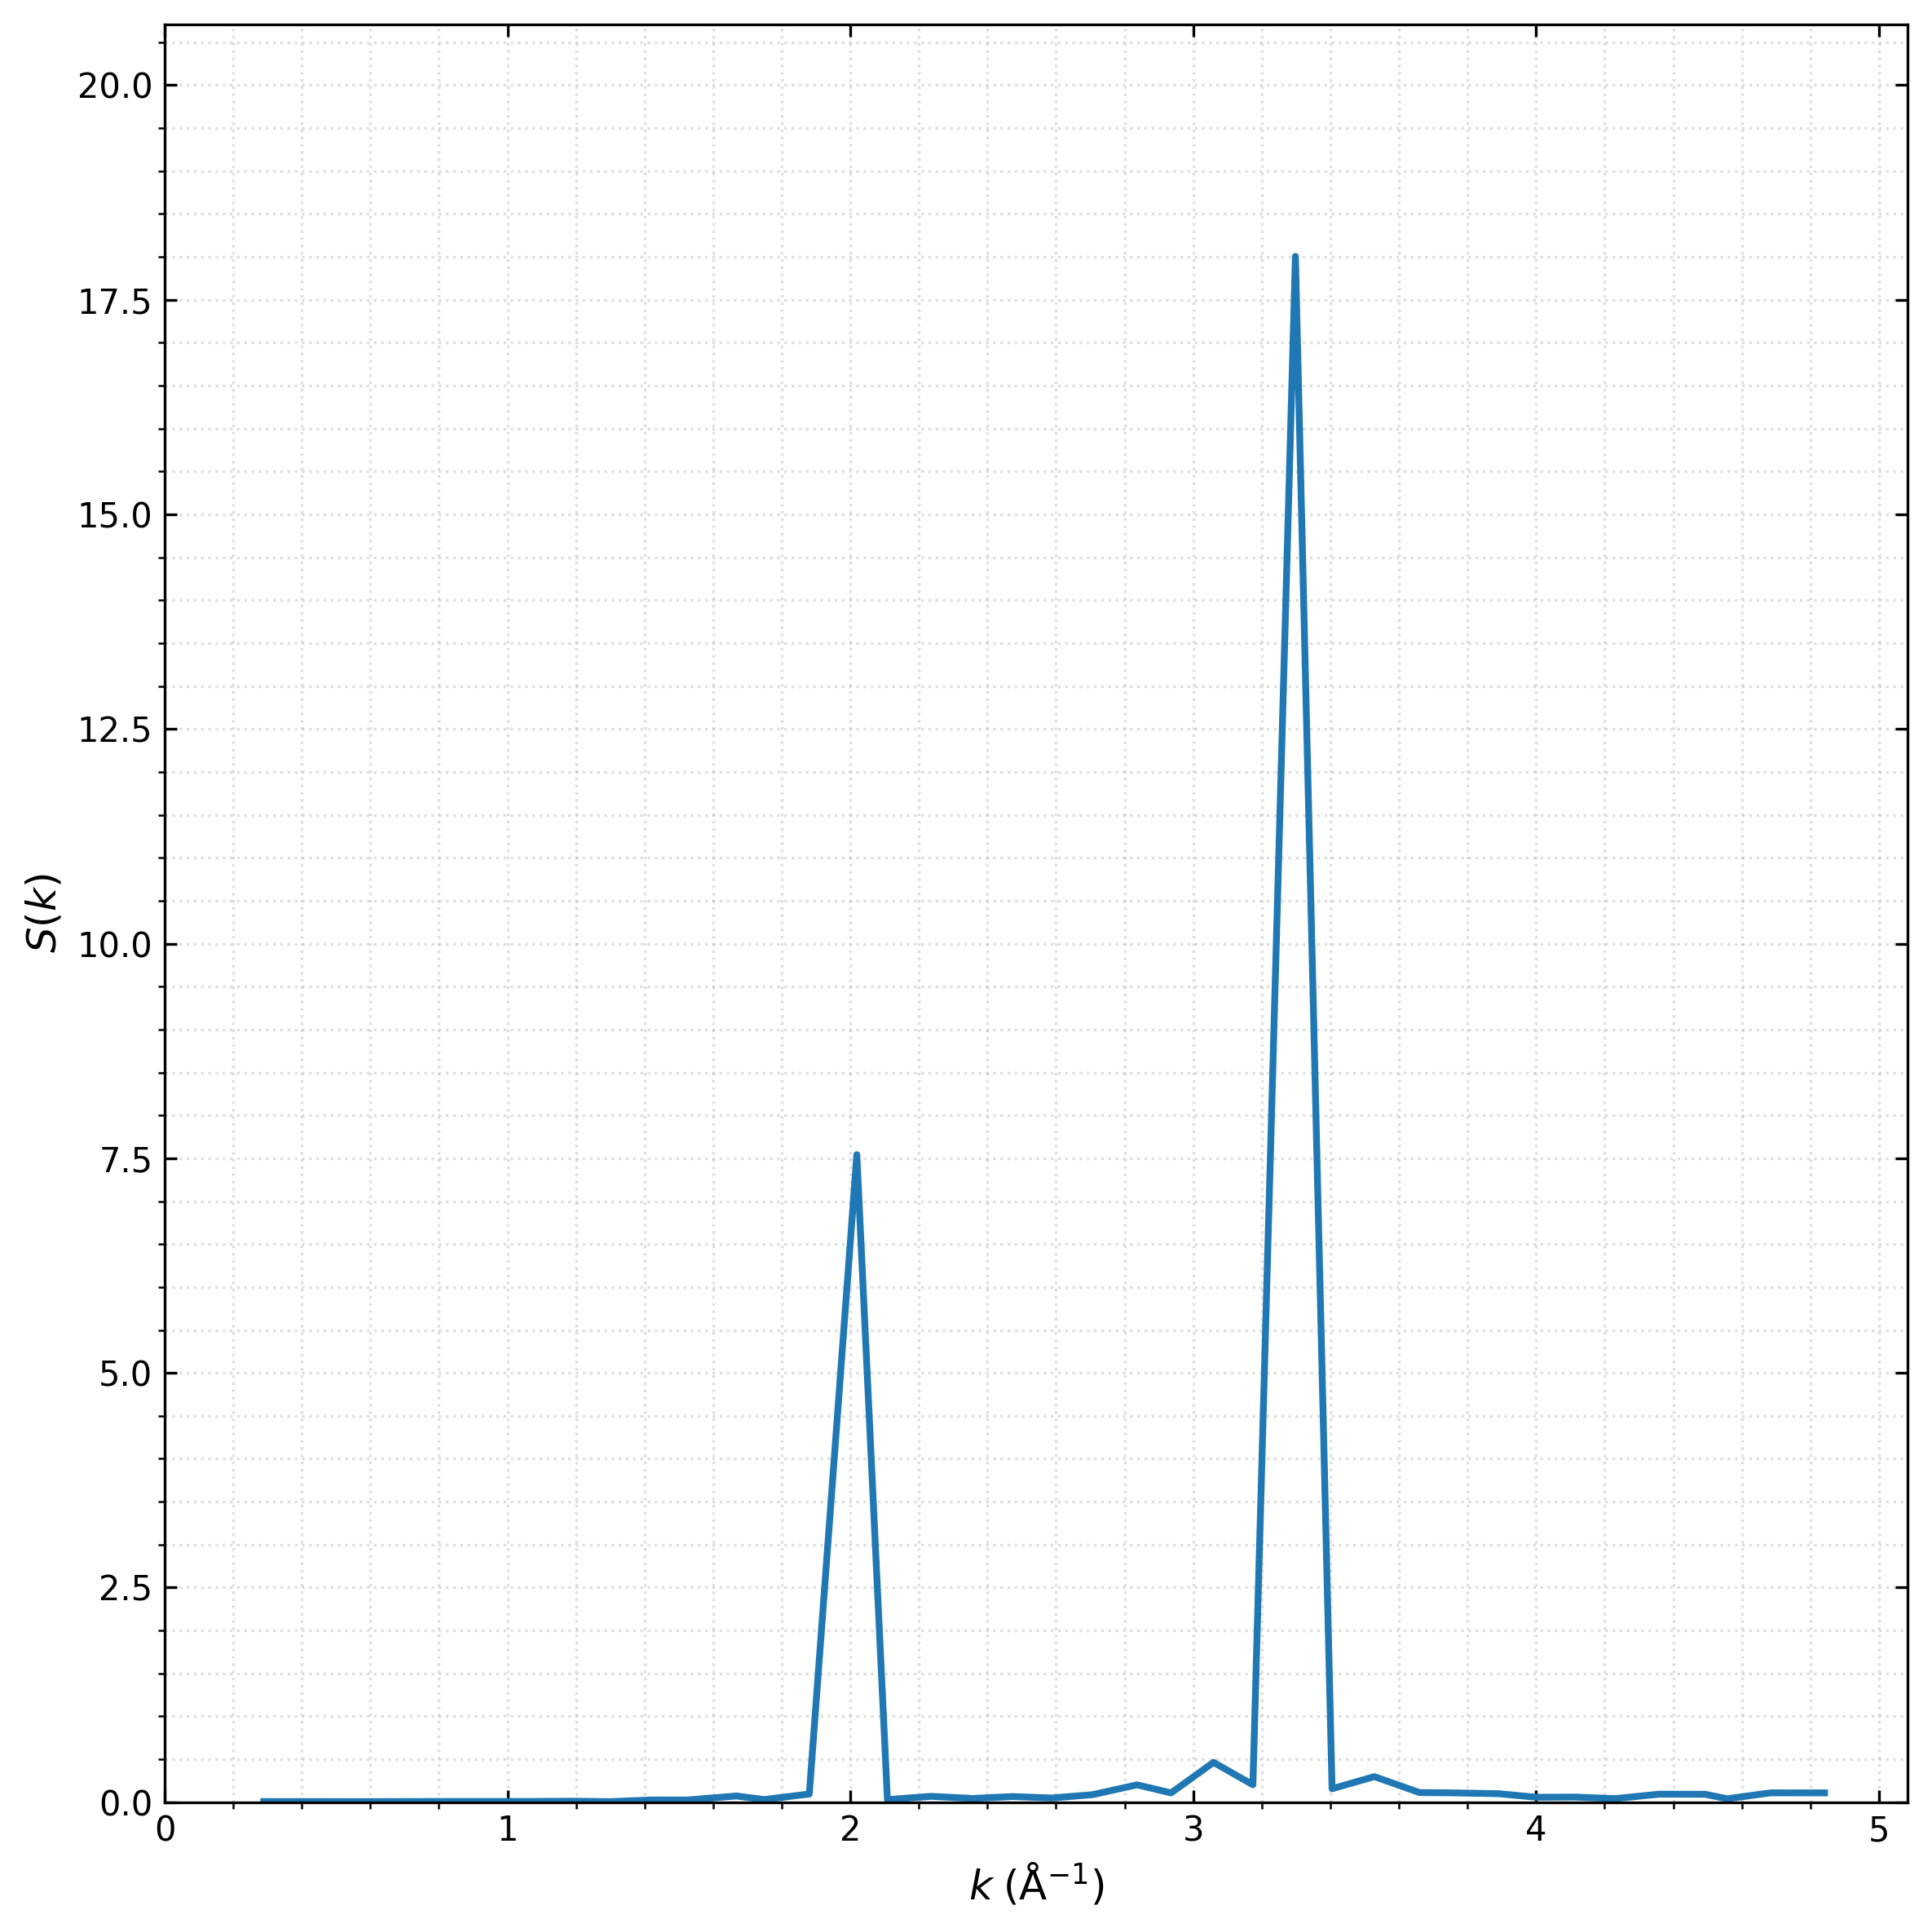

In [6]:
#Structural Factor S(K).
def legal_kvecs(maxn, L):
    """
    Generate k-vectors commensurate with the cubic box with size L.
    Only keep the all-positive octant.
    k = 2π/L * (nx, ny, nz); nx, ny, nz = 0, 1, 2, 3, ..., maxn. Set maxn = 10.
    """
    k0 = 2.0 * np.pi / float(L)
    n = np.arange(maxn + 1)
    nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")
    kvecs = np.column_stack([nx.ravel(), ny.ravel(), nz.ravel()])
    return k0 * kvecs

def calc_rhok(kvecs, pos):
    """
    ρ_k = Σ_j exp(-i k · r_j)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    phase = kvecs @ pos.T
    rhok = np.exp(-1j * phase).sum(axis = 1)
    return rhok

def calc_Sk(kvecs, pos):
    """
    S(k) = (1/N) ⟨ρ_k ρ_-k⟩ = |ρ_k|^2 / N  (single configuration)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    N = pos.shape[0]
    rhok = calc_rhok(kvecs, pos)
    Sk = (rhok * np.conjugate(rhok)).real / N
    return Sk

def compute_structure_factor(positions, box, maxn_k = 10, k_cut = None, nbins_k = 40):
    """
    Compute S(K) in single configuration.
    """
    L = float(min(box))
    kvecs_all = legal_kvecs(maxn_k, L)
    k_mag_all = np.linalg.norm(kvecs_all, axis = 1)
    #Remove k = 0
    cutoff = k_mag_all > 0
    kvecs = kvecs_all[cutoff]
    k_mag = k_mag_all[cutoff]
    #In case to zoom in for comparison, change here.
    if k_cut is not None:
        cutoff2 = k_mag < k_cut
        kvecs = kvecs[cutoff2]
        k_mag = k_mag[cutoff2]
    
    Sk = calc_Sk(kvecs, positions)

    # Bin by |k| to get isotropic S(k)
    nbins = nbins_k
    kmin, kmax = k_mag.min(), k_mag.max()
    bins = np.linspace(kmin, kmax, nbins + 1)
    bin_idx = np.digitize(k_mag, bins) - 1
    k_bin_list, Sk_bin_list = [], []

    for ib in range(nbins):
        mask_b = bin_idx == ib
        if np.any(mask_b):
            k_bin_list.append(k_mag[mask_b].mean())
            Sk_bin_list.append(Sk[mask_b].mean())

    k_bin = np.array(k_bin_list)
    Sk_bin = np.array(Sk_bin_list)
    return k_bin, Sk_bin

def plot_Sk(k, Sk, outfile = "Structure_Factor.png"):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(k, Sk, linewidth = 2.0)
    ax.set_xlabel(r"$k \; (\mathrm{\AA^{-1}})$", fontsize = 12)
    ax.set_ylabel(r"$S(k)$", fontsize = 12)
    ax.set_xlim(0, k.max() * 1.05)
    ax.set_ylim(0, Sk.max() * 1.15)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.show()

def main_Sk():
    data_file = "700 K 5 Vacancy/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")

    maxn_k = 10
    k_cut = None
    nbins_k = 40

    k_bin, Sk_bin = compute_structure_factor(
        positions, box, maxn_k=maxn_k, k_cut=k_cut, nbins_k=nbins_k
    )

    np.savetxt(
        "700 K 5 Vacancy/Sk.dat",
        np.column_stack((k_bin, Sk_bin)),
        header="k(1/Å)   S(k)   (FINAL_STRUCTURE)",
    )
    plot_Sk(k_bin, Sk_bin, outfile="700 K 5 Vacancy/Structure_Factor.png")


if __name__ == "__main__":
    main_Sk()

700-5-int